# **LAB-08 CLASIFICACIÓN DE TEXTO**

### Nombre: GONZALES SUYO FRANZ REINALDO
### Dirección de GitHub: https://github.com/Gonzales-Franz-Reinaldo/SIS421-IA2/tree/main/Laboratorios/LAB-08_NLP

## IMPORTACIONES DE LAS LIBRERIAS

# UTILIZAMOS EL MODELO PRE-ENTRENADO ALBERT

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import torch
import random
import numpy as np
# KFold: se utiliza para realizar validación cruzada, dividiendo el dataset en múltiples pliegues.
from sklearn.model_selection import train_test_split, KFold
# AlbertTokenizer: Convierte el texto en tokens que el modelo ALBERT puede entender.
# AlbertForSequenceClassification:  Carga el modelo ALBERT para la tarea específica de clasificación de secuencias.
# Trainer: Simplifica el proceso de entrenamiento del modelo.
# TrainingArguments: Permite configurar los parámetros del entrenamiento.
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments

# precision_recall_fscore_support: Calcula precisión, recall, F1, y soporte.
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import nltk  # nltk: es una biblioteca de procesamiento de lenguaje natural.

# Descargar recursos de NLTK
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

En el contexto de la clasificación de texto: nltk se utiliza aquí para data augmentation, utilizando sinónimos del corpus WordNet para crear versiones alternativas de las oraciones, lo cual ayuda a expandir el dataset y mejorar el entrenamiento en datasets pequeños.

In [ ]:
# 1. Cargar el archivo CSV desde Google Drive
# Conéctate a Google Drive (requiere autorización de Google)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1: Cargar y Preparar el Dataset

In [ ]:
# Ruta del archivo CSV en Google Drive
file_path = '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-08_Clasificacion_Texto/dataset_clasificacion.csv'
df = pd.read_csv(file_path)

In [ ]:
print(df.head())

                                               texto               categoria
0  Este documento presenta el Modelo Academico qu...  Academico y Evaluacion
1  La Universidad se compromete a formar profesio...  Academico y Evaluacion
2  El modelo académico incluye un enfoque socio-s...  Academico y Evaluacion
3  El Centro de Interacción Social, Investigación...  Academico y Evaluacion
4  El Modelo Academico de 20o0 en la Universidad ...  Academico y Evaluacion


In [ ]:
# Limpieza y normalización de textos
df['texto'] = df['texto'].str.lower()  # Convertir a minúsculas para uniformidad
df = df.dropna()  # Eliminar filas con valores nulos si existen

In [ ]:
df['texto']

,texto
0,este documento presenta el modelo academico qu...
1,la universidad se compromete a formar profesio...
2,el modelo académico incluye un enfoque socio-s...
3,"el centro de interacción social, investigación..."
4,el modelo academico de 20o0 en la universidad ...
...,...
97,este reglamento regula el uso y distribución d...
98,objetivo: regular la administración y aplicaci...
99,los recursos del idh pueden destinarse hasta u...
100,restricciones: el monto total anual de recurso...


In [ ]:
# Codificación de etiquetas
labels = df['categoria'].unique()
# Creamos un diccionario  que asigna un número (índice) a cada categoría.
label_dict = {label: index for index, label in enumerate(labels)}
df['categoria'] = df['categoria'].map(label_dict)

In [ ]:
df['categoria']

,categoria
0,0
1,0
2,0
3,0
4,0
...,...
97,2
98,2
99,2
100,2


## 2: Data Augmentation
En este bloque, aplicamos data augmentation mediante el uso de sinónimos para crear versiones alternativas de las oraciones.

In [ ]:
# WordNet es una base de datos léxica en inglés que contiene sinónimos para palabras.
from nltk.corpus import wordnet

# Función de data augmentation
def augment_text(text):
    words = text.split() # El texto se divide en una lista de palabras.
    augmented_text = []

    for word in words:
        synonyms = []
        # Buscamos sinónimos para la palabra en WordNet.
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Si se encuentran sinónimos, se selecciona el primero en la lista
            synonym = synonyms[0].lemmas()[0].name()
            augmented_text.append(synonym) # Agrega al texto aumentado
        else:
            # Si encuentra se conserva la palabra original.
            augmented_text.append(word)
    return ' '.join(augmented_text)



# Aumentar el dataset en un 50%
# Controla el porcentaje de datos que se aumentarán (en este caso, un 50%).
augmentation_factor = 0.5
augmented_texts = []
augmented_labels = []

for _, row in df.iterrows():
    if random.random() < augmentation_factor:
        augmented_texts.append(augment_text(row['texto']))
        augmented_labels.append(row['categoria'])

# Crear DataFrame final con textos originales y aumentados
aug_df = pd.DataFrame({'texto': augmented_texts, 'categoria': augmented_labels})
df = pd.concat([df, aug_df], ignore_index=True)


In [ ]:
import random
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')

# Cargar stopwords para inglés (puedes cambiarlas a otro idioma si es necesario)
stop_words = set(stopwords.words('english'))

# Función para invertir palabras en una oración
def shuffle_words(text):
    words = text.split()
    random.shuffle(words)  # Cambia el orden de las palabras
    return ' '.join(words)

# Función para eliminar palabras menos importantes (stopwords)
def remove_stopwords(text):
    words = text.split()
    # Mantiene las palabras que no están en la lista de stopwords
    important_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(important_words)

# Función de sinonimización usando WordNet
def synonym_replacement(text):
    words = text.split()
    augmented_text = []

    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()  # Selecciona el primer sinónimo
            augmented_text.append(synonym)
        else:
            augmented_text.append(word)
    return ' '.join(augmented_text)

# Función de data augmentation avanzada combinando todas las técnicas
def advanced_augment_text(text):
    # Aplicar cada técnica de data augmentation con una probabilidad del 50%
    if random.random() < 0.5:
        text = shuffle_words(text)  # Inversión de palabras
    if random.random() < 0.5:
        text = remove_stopwords(text)  # Eliminación de palabras menos importantes
    if random.random() < 0.5:
        text = synonym_replacement(text)  # Sinonimización

    return text

# Aumentar el dataset en un 60%
augmentation_factor = 0.6
augmented_texts = []
augmented_labels = []

# Aplicar data augmentation avanzada a un porcentaje del dataset
for _, row in df.iterrows():
    if random.random() < augmentation_factor:
        augmented_texts.append(advanced_augment_text(row['texto']))
        augmented_labels.append(row['categoria'])

# Crear DataFrame final con textos originales y aumentados
aug_df = pd.DataFrame({'texto': augmented_texts, 'categoria': augmented_labels})
df = pd.concat([df, aug_df], ignore_index=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df

,texto,categoria
0,este documento presenta el modelo academico qu...,0
1,la universidad se compromete a formar profesio...,0
2,el modelo académico incluye un enfoque socio-s...,0
3,"el centro de interacción social, investigación...",0
4,el modelo academico de 20o0 en la universidad ...,0
...,...,...
247,este reglamento establece las normas para el p...,0
248,grado. ensayo profesional elevation profesiona...,0
249,"beneficien francisco este impuesto que mayor, ...",2
250,"Delaware universitarios, beneficiar guarderías...",2


La data augmentation es especialmente valiosa cuando se trabaja con un dataset pequeño, ya que introduce variabilidad en los datos sin cambiar el significado de los textos.

## 3: Configuración del Dataset y Tokenización
Preparamos el dataset en un formato que el modelo pueda procesar, utilizando AlbertTokenizer para tokenizar los textos.

In [ ]:
# tokenizador específico de ALBERT, un modelo de transformers preentrenado.
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# El tokenizador convierte el texto en tokens y IDs que el modelo ALBERT puede entender
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

AlbertTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len #  La longitud máxima de cada secuencia de tokens

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        # El tokenizador transforma el texto en una secuencia de tokens
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        # El resultado de encoding es un diccionario que incluye:
        #-input_ids: La secuencia de tokens numéricos.
        #- attention_mask: Máscara de atención que indica qué tokens son de relleno (0 para tokens de relleno, 1 para tokens útiles).

        return {'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)}


En esta clase dataset personalizado para la clasificación de texto, utilizando el modelo ALBERT de Hugging Face. La clase TextDataset permite estructurar los textos y etiquetas en un formato que PyTorch puede procesar durante el entrenamiento. Este dataset se usa para entrenar modelos de clasificación de texto, como ALBERT, al organizar los datos en el formato adecuado para la entrada al modelo.

## 4: Configuración de Validación Cruzada y Entrenamiento con ALBERT HACIENDO FINE-TUNING

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from transformers import Trainer, TrainingArguments
import os
from pathlib import Path

# Importar KFold de scikit-learn para realizar la validación cruzada
kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # Crear 5 divisiones aleatorias del conjunto de datos

# Diccionario para almacenar las métricas de cada fold
results = {"accuracy": [], "f1": [], "precision": [], "recall": []}

# Iniciar el contador de folds
fold = 1
# Loop para cada fold de validación cruzada
for train_index, val_index in kfold.split(df):
    # Dividir el conjunto de datos en entrenamiento y validación según los índices actuales
    train_texts, val_texts = df.iloc[train_index]['texto'], df.iloc[val_index]['texto']
    train_labels, val_labels = df.iloc[train_index]['categoria'], df.iloc[val_index]['categoria']

    # Crear datasets personalizados para entrenamiento y validación
    train_dataset = TextDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)

    # Cargar el modelo ALBERT preentrenado para clasificación con el número de etiquetas adecuado
    model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(label_dict))

    # Definir una función para calcular las métricas de evaluación del modelo
    def compute_metrics(pred):
        labels = pred.label_ids  # Etiquetas verdaderas
        preds = pred.predictions.argmax(-1)  # Predicciones del modelo (argmax selecciona la clase con mayor probabilidad)
        # Calcular precisión, recuperación y F1 usando promedio ponderado
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)  # Calcular exactitud (accuracy)
        return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}  # Retornar las métricas calculadas

    # Configuración de los argumentos de entrenamiento
    training_args = TrainingArguments(
        output_dir=f'/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-08_Clasificacion_Texto/Checkpoint/fold_{fold}',  # Directorio de salida
        evaluation_strategy='epoch',  # Evaluar el modelo al final de cada época
        save_strategy='epoch',  # Guardar el modelo al final de cada época
        save_steps=2,  # Guardar un checkpoint cada 2 épocas
        per_device_train_batch_size=16,  # Tamaño de batch para entrenamiento
        per_device_eval_batch_size=16,  # Tamaño de batch para evaluación
        num_train_epochs=15,  # Número de épocas de entrenamiento
        weight_decay=0.02,  # Decaimiento de pesos para regularización
        learning_rate=3e-5,  # Tasa de aprendizaje reducida
        logging_dir='./logs',  # Directorio para guardar los logs de entrenamiento
        logging_steps=10,  # Intervalo de logging durante el entrenamiento
        load_best_model_at_end=True,  # Cargar el mejor modelo al final del entrenamiento
        metric_for_best_model="f1",  # Métrica a utilizar para seleccionar el mejor modelo
        greater_is_better=True  # Configurar para elegir el modelo con mayor f1
    )

    # Crear el objeto Trainer, encargado de gestionar el entrenamiento y evaluación
    trainer = Trainer(
        model=model,  # Modelo a entrenar
        args=training_args,  # Argumentos de entrenamiento
        train_dataset=train_dataset,  # Conjunto de datos de entrenamiento
        eval_dataset=val_dataset,  # Conjunto de datos de validación
        compute_metrics=compute_metrics,  # Función de evaluación personalizada
        tokenizer=tokenizer  # Tokenizador del modelo ALBERT
    )

    # Entrenamiento del modelo en el fold actual
    print("Iniciando entrenamiento con ajustes...")
    print(f'Entrenando Fold {fold}...')
    trainer.train()

    # Evaluación del modelo en el conjunto de validación y almacenamiento de las métricas
    metrics = trainer.evaluate()
    results["accuracy"].append(metrics["eval_accuracy"])  # Guardar la exactitud
    results["f1"].append(metrics["eval_f1"])  # Guardar F1
    results["precision"].append(metrics["eval_precision"])  # Guardar precisión
    results["recall"].append(metrics["eval_recall"])  # Guardar recuperación
    print(f'Métricas del Fold {fold}:', metrics)  # Imprimir las métricas del fold actual

    # Incrementar el número del fold
    fold += 1

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 1...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.625000,1.537038,0.461538,0.335664,0.321070,0.461538
2,1.645700,1.683145,0.115385,0.077330,0.236923,0.115385
3,1.637900,1.547965,0.269231,0.174531,0.130070,0.269231
4,1.576000,1.560984,0.269231,0.150000,0.173077,0.269231
5,1.474000,1.609387,0.230769,0.237222,0.697436,0.230769
6,1.271800,1.269413,0.500000,0.488529,0.668376,0.500000
7,1.104700,1.529975,0.230769,0.232507,0.620147,0.230769
8,0.910800,1.148908,0.576923,0.613183,0.698535,0.576923
9,0.704000,1.005998,0.538462,0.470798,0.514706,0.538462
10,0.418500,0.611431,0.884615,0.874753,0.895604,0.884615


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Métricas del Fold 1: {'eval_loss': 0.2546895146369934, 'eval_accuracy': 0.9615384615384616, 'eval_f1': 0.9620056057303021, 'eval_precision': 0.967032967032967, 'eval_recall': 0.9615384615384616, 'eval_runtime': 0.4331, 'eval_samples_per_second': 60.031, 'eval_steps_per_second': 4.618, 'epoch': 15.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 2...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.605200,1.601754,0.230769,0.086538,0.053254,0.230769
2,1.626400,1.554417,0.307692,0.144796,0.094675,0.307692
3,1.619700,1.570673,0.423077,0.317949,0.342657,0.423077
4,1.623500,1.599258,0.192308,0.082418,0.052448,0.192308
5,1.610300,1.621677,0.230769,0.197239,0.215385,0.230769
6,1.601700,1.593536,0.230769,0.086538,0.053254,0.230769
7,1.628700,1.577422,0.307692,0.144796,0.094675,0.307692
8,1.561100,1.583848,0.230769,0.086538,0.053254,0.230769
9,1.612800,1.564174,0.230769,0.086538,0.053254,0.230769
10,1.604800,1.601367,0.230769,0.086538,0.053254,0.230769


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Métricas del Fold 2: {'eval_loss': 1.5706725120544434, 'eval_accuracy': 0.4230769230769231, 'eval_f1': 0.31794871794871793, 'eval_precision': 0.3426573426573427, 'eval_recall': 0.4230769230769231, 'eval_runtime': 0.4151, 'eval_samples_per_second': 62.631, 'eval_steps_per_second': 4.818, 'epoch': 15.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 3...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.611900,1.584846,0.240000,0.138966,0.321667,0.240000
2,1.568200,1.540525,0.320000,0.212564,0.192632,0.320000
3,1.501000,1.524702,0.240000,0.130074,0.138788,0.240000
4,1.459300,1.344528,0.480000,0.391111,0.356923,0.480000
5,1.379700,1.399629,0.320000,0.203230,0.149444,0.320000
6,1.288600,1.334346,0.520000,0.441930,0.446429,0.520000
7,1.171500,1.269827,0.520000,0.429549,0.458095,0.520000
8,1.079200,1.162132,0.560000,0.529829,0.590256,0.560000
9,0.958500,1.188308,0.480000,0.414118,0.404952,0.480000
10,0.840400,0.994671,0.560000,0.550303,0.616508,0.560000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Métricas del Fold 3: {'eval_loss': 0.7504441738128662, 'eval_accuracy': 0.72, 'eval_f1': 0.7095238095238097, 'eval_precision': 0.7511111111111112, 'eval_recall': 0.72, 'eval_runtime': 0.4102, 'eval_samples_per_second': 60.949, 'eval_steps_per_second': 4.876, 'epoch': 15.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 4...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.618300,1.699417,0.200000,0.066667,0.040000,0.200000
2,1.580700,1.680635,0.200000,0.068966,0.041667,0.200000
3,1.636100,1.653435,0.240000,0.141693,0.441667,0.240000
4,1.508100,1.484177,0.520000,0.497353,0.540433,0.520000
5,1.316800,1.368279,0.480000,0.431990,0.551923,0.480000
6,1.134700,1.436536,0.520000,0.480321,0.578824,0.520000
7,0.956600,1.131630,0.720000,0.702745,0.740000,0.720000
8,0.604100,0.860305,0.800000,0.771287,0.770413,0.800000
9,0.490000,0.850030,0.800000,0.792269,0.831111,0.800000
10,0.378100,0.571776,0.840000,0.853333,0.900000,0.840000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Métricas del Fold 4: {'eval_loss': 0.46661150455474854, 'eval_accuracy': 0.88, 'eval_f1': 0.8618181818181818, 'eval_precision': 0.8466666666666667, 'eval_recall': 0.88, 'eval_runtime': 0.403, 'eval_samples_per_second': 62.042, 'eval_steps_per_second': 4.963, 'epoch': 15.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 5...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.626600,1.597757,0.280000,0.126452,0.081667,0.280000
2,1.631800,1.558988,0.280000,0.126452,0.081667,0.280000
3,1.599000,1.512506,0.440000,0.361256,0.314667,0.440000
4,1.562900,1.516792,0.480000,0.402435,0.455833,0.480000
5,1.574800,1.469352,0.320000,0.238431,0.192000,0.320000
6,1.394600,1.352054,0.520000,0.504837,0.564127,0.520000
7,1.375500,1.305521,0.440000,0.402564,0.407692,0.440000
8,1.147600,1.160321,0.560000,0.516484,0.511111,0.560000
9,0.968400,1.166020,0.600000,0.593333,0.711299,0.600000
10,0.702400,0.894391,0.800000,0.789333,0.847667,0.800000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Métricas del Fold 5: {'eval_loss': 0.7324349880218506, 'eval_accuracy': 0.84, 'eval_f1': 0.8440000000000001, 'eval_precision': 0.8826666666666667, 'eval_recall': 0.84, 'eval_runtime': 0.405, 'eval_samples_per_second': 61.727, 'eval_steps_per_second': 4.938, 'epoch': 15.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 6...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.613200,1.652713,0.200000,0.066667,0.040000,0.200000
2,1.531300,1.515747,0.400000,0.327308,0.294545,0.400000
3,1.425500,1.426617,0.320000,0.303158,0.344190,0.320000
4,1.193500,1.301687,0.440000,0.372406,0.336667,0.440000
5,1.037200,1.166616,0.480000,0.453571,0.474545,0.480000
6,0.931100,1.049799,0.560000,0.520085,0.518667,0.560000
7,0.766800,1.101467,0.560000,0.519524,0.525000,0.560000
8,0.565800,1.031396,0.520000,0.475540,0.488000,0.520000
9,0.469100,0.796625,0.600000,0.557778,0.545714,0.600000
10,0.403900,0.774693,0.680000,0.611223,0.571714,0.680000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Métricas del Fold 6: {'eval_loss': 0.6726382374763489, 'eval_accuracy': 0.8, 'eval_f1': 0.784873949579832, 'eval_precision': 0.836, 'eval_recall': 0.8, 'eval_runtime': 0.4082, 'eval_samples_per_second': 61.251, 'eval_steps_per_second': 4.9, 'epoch': 15.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 7...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.618000,1.681695,0.160000,0.047407,0.027826,0.160000
2,1.566700,1.520194,0.360000,0.265714,0.285333,0.360000
3,1.592000,1.628733,0.200000,0.116571,0.090000,0.200000
4,1.489100,1.516890,0.360000,0.318357,0.300121,0.360000
5,1.447600,1.494110,0.400000,0.370337,0.412182,0.400000
6,1.211100,1.562837,0.360000,0.342626,0.688889,0.360000
7,1.213600,1.398021,0.480000,0.474545,0.757333,0.480000
8,0.907700,1.130123,0.560000,0.558154,0.726667,0.560000
9,0.730200,1.021374,0.680000,0.716063,0.840000,0.680000
10,0.531000,0.784358,0.760000,0.792889,0.902857,0.760000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Métricas del Fold 7: {'eval_loss': 0.6410824060440063, 'eval_accuracy': 0.76, 'eval_f1': 0.7932698412698413, 'eval_precision': 0.8895238095238095, 'eval_recall': 0.76, 'eval_runtime': 0.4407, 'eval_samples_per_second': 56.729, 'eval_steps_per_second': 4.538, 'epoch': 15.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 8...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.645700,1.626972,0.120000,0.063776,0.072000,0.120000
2,1.551200,1.702607,0.160000,0.093333,0.087273,0.160000
3,1.467400,1.636560,0.240000,0.156639,0.148381,0.240000
4,1.162000,1.651095,0.320000,0.279524,0.328095,0.320000
5,1.016600,1.380275,0.520000,0.466593,0.475000,0.520000
6,0.706700,1.450139,0.440000,0.380000,0.360000,0.440000
7,0.567500,1.413891,0.440000,0.369778,0.358571,0.440000
8,0.339400,1.326143,0.520000,0.465801,0.471667,0.520000
9,0.290300,1.401259,0.480000,0.403333,0.386667,0.480000
10,0.154700,1.311457,0.600000,0.548104,0.553333,0.600000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Métricas del Fold 8: {'eval_loss': 1.43336820602417, 'eval_accuracy': 0.56, 'eval_f1': 0.5518974358974359, 'eval_precision': 0.6942857142857143, 'eval_recall': 0.56, 'eval_runtime': 0.4024, 'eval_samples_per_second': 62.132, 'eval_steps_per_second': 4.971, 'epoch': 15.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 9...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.649200,1.541563,0.360000,0.234176,0.176000,0.360000
2,1.555200,1.465062,0.480000,0.391453,0.382588,0.480000
3,1.417500,1.477222,0.440000,0.432571,0.700000,0.440000
4,1.289200,1.239108,0.640000,0.615273,0.638571,0.640000
5,1.019200,0.985972,0.640000,0.609870,0.621000,0.640000
6,0.720700,0.915198,0.640000,0.616667,0.600000,0.640000
7,0.612700,0.711679,0.720000,0.689263,0.678667,0.720000
8,0.475700,0.684422,0.800000,0.801994,0.821000,0.800000
9,0.382000,0.827962,0.680000,0.677853,0.696000,0.680000
10,0.288800,0.725636,0.800000,0.804681,0.854286,0.800000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Métricas del Fold 9: {'eval_loss': 0.712709903717041, 'eval_accuracy': 0.8, 'eval_f1': 0.8151428571428571, 'eval_precision': 0.88, 'eval_recall': 0.8, 'eval_runtime': 0.4003, 'eval_samples_per_second': 62.458, 'eval_steps_per_second': 4.997, 'epoch': 15.0}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-09fcf438f324>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento con ajustes...
Entrenando Fold 10...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.611600,1.682007,0.240000,0.148986,0.145684,0.240000
2,1.575300,1.602212,0.320000,0.210286,0.177647,0.320000
3,1.503400,1.629013,0.280000,0.256471,0.324923,0.280000
4,1.471100,1.618086,0.280000,0.249846,0.314667,0.280000
5,1.380300,1.508556,0.440000,0.392000,0.373333,0.440000
6,1.285200,1.465641,0.400000,0.379865,0.446923,0.400000
7,1.127400,1.375911,0.440000,0.402909,0.397333,0.440000
8,0.973000,1.301868,0.520000,0.490874,0.692182,0.520000
9,0.822100,1.127865,0.600000,0.571905,0.766667,0.600000
10,0.653500,1.206110,0.480000,0.474769,0.497524,0.480000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Métricas del Fold 10: {'eval_loss': 1.026279330253601, 'eval_accuracy': 0.64, 'eval_f1': 0.6356923076923077, 'eval_precision': 0.7204761904761904, 'eval_recall': 0.64, 'eval_runtime': 0.403, 'eval_samples_per_second': 62.042, 'eval_steps_per_second': 4.963, 'epoch': 15.0}


## 5: Visualización de Métricas y Evaluación Final
Este bloque muestra el rendimiento del modelo en cada fold.

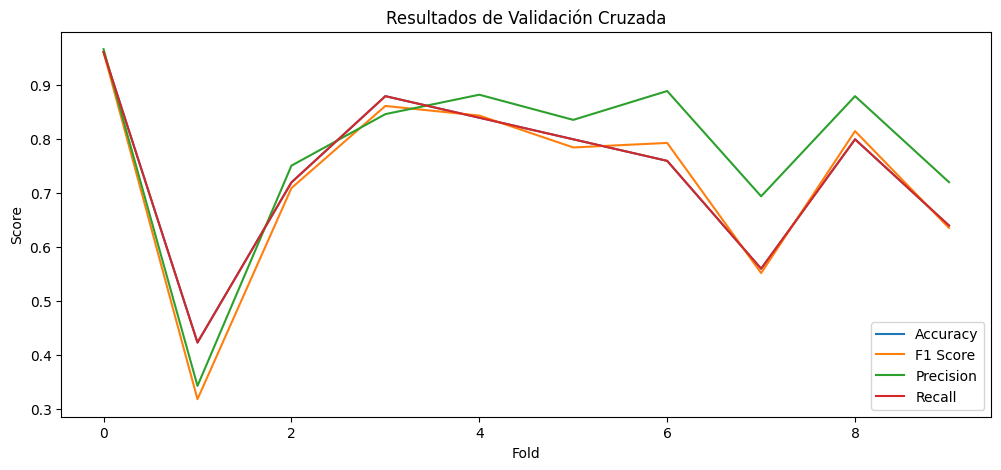

In [ ]:
# Visualización de resultados
plt.figure(figsize=(12, 5))
plt.plot(results["accuracy"], label='Accuracy')
plt.plot(results["f1"], label='F1 Score')  # Un puntaje F1 más alto indica un mejor equilibrio entre precisión y recall.
plt.plot(results["precision"], label='Precision')
plt.plot(results["recall"], label='Recall')  # Mide cuántos de los ejemplos reales positivos fueron correctamente identificados por el modelo.
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Resultados de Validación Cruzada')
plt.legend()
plt.show()

# Mostrar resultados promedios
print("\n--- Resultados Promedio de Validación Cruzada ---")
print("Exactitud:", np.mean(results["accuracy"]))
print("F1 Score:", np.mean(results["f1"]))
print("Precisión:", np.mean(results["precision"]))
print("Recall:", np.mean(results["recall"]))


## 6: Pruebas y Predicciones
Finalmente, probamos el modelo con un texto de ejemplo.

In [ ]:
import os
from pathlib import Path

# Función para cargar el último checkpoint en una carpeta específica
def load_latest_checkpoint(folder_path):
    checkpoint_dirs = [Path(folder_path) / d for d in os.listdir(folder_path) if d.startswith("checkpoint-")]
    latest_checkpoint = max(checkpoint_dirs, key=os.path.getmtime)  # Obtener el checkpoint más reciente
    print(f"Cargando el último checkpoint desde: {latest_checkpoint}")
    return latest_checkpoint

# Ruta del checkpoint en el último fold para cargar el modelo entrenado
last_fold_checkpoint_path = f'/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-08_Clasificacion_Texto/Checkpoint/fold_{fold - 2}'
latest_checkpoint = load_latest_checkpoint(last_fold_checkpoint_path)


Cargando el último checkpoint desde: /content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-08_Clasificacion_Texto/Checkpoint/fold_9/checkpoint-225


In [ ]:
# Cargar el modelo desde el último checkpoint
model = AlbertForSequenceClassification.from_pretrained(latest_checkpoint)
model

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
# Función de predicción con el modelo cargado
def predict(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return list(label_dict.keys())[list(label_dict.values()).index(prediction)]

# Prueba de predicción
texto_prueba = "Regular la administración y aplicación de los recursos del IDH destinados a proyectos de infraestructura y equipamiento en la universidad, con un enfoque en el bienestar estudiantil."
print(f"Texto de prueba: {texto_prueba}")
print("Predicción de categoría:", predict(texto_prueba, model, tokenizer))

Texto de prueba: Regular la administración y aplicación de los recursos del IDH destinados a proyectos de infraestructura y equipamiento en la universidad, con un enfoque en el bienestar estudiantil.
Predicción de categoría: Apoyo y Bienestar Estudiantil


In [ ]:
# Prueba de predicción
texto_prueba2 = "La Universidad se compromete a formar profesionales con conciencia social, principios democráticos, y respeto por el medio ambiente, orientados al desarrollo social y científico."
print(f"Texto de prueba: {texto_prueba2}")
print("Predicción de categoría:", predict(texto_prueba2, model, tokenizer))

Texto de prueba: La Universidad se compromete a formar profesionales con conciencia social, principios democráticos, y respeto por el medio ambiente, orientados al desarrollo social y científico.
Predicción de categoría: Academico y Evaluacion


In [ ]:
# Prueba de predicción
texto_prueba3 = "La universidad cuenta con financiamiento propio y colabora con instituciones externas para el desarrollo de proyectos. El DICyT administra estos recursos, apoyando tanto proyectos pequeños como investigaciones de gran envergadura."
print(f"Texto de prueba: {texto_prueba3}")
print("Predicción de categoría:", predict(texto_prueba3, model, tokenizer))

Texto de prueba: La universidad cuenta con financiamiento propio y colabora con instituciones externas para el desarrollo de proyectos. El DICyT administra estos recursos, apoyando tanto proyectos pequeños como investigaciones de gran envergadura.
Predicción de categoría: Apoyo y Bienestar Estudiantil
